# Road line detection project

# Importing some useful packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

# Reading in an image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


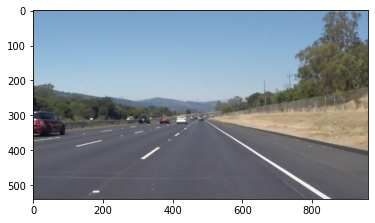

In [2]:
image = mpimg.imread('solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

## Applies the Grayscale transform 
This will return an image with only one color channel but NOTE: 
to see the returned image as grayscale you should call plt.imshow(gray, cmap='gray')

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Applies the Canny transform
As the name suggests, it is an algorithm to detect edges in our image. A change in intensity of pixels will give us an edge.
Small change will imply small change in intensity whereas a Large derivative is a large change.
If a gradient is larger than the high_threshold, then it is accepted as an edge pixel. If it is below the low_threshold, it is rejected. 

In [4]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

## Applies a Gaussian Noise kernel
Used to reduce noise and smoothen out the image. We generally use a kernel of some specific size and a deviation

In [5]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Applies an image mask.
Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of the image is set to black.

In [6]:
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Draw line
NOTE: this is the function you might want to use as a starting point once you want to average/extrapolate the line segments you detect to map out the full
extent of the lane
    
Think about things like separating line segments by their slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left line vs. the right line.  Then, you can average the position of each of the lines and extrapolate to the top and bottom of the lane.
    
This function draws `lines` with `color` and `thickness`. Lines are drawn on the image inplace (mutates the image).If you want to make the lines semi-transparent, think about combining this function with the weighted_img() function below

In [7]:
def draw_lines(img, lines, color=[0, 255, 0], thickness=10):
    # In case of error, don't draw the line
    draw_right = True
    draw_left = True
    
    # Find slopes of all lines
    # But only care about lines where abs(slope) > slope_threshold
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
    # Split lines into right_lines and left_lines, representing the right and left lane lines
    # Right/left lane lines must have positive/negative slope, and be on the right/left half of the image
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    # Run linear regression to find best fit line for right and left lane lines
    # Right lane lines
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    # Find 2 end points for right and left lines, used for drawing the line
    # y = m*x + b --> x = (y - b)/m
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert calculated end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the right and left lines on image
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

## Hough Transform
The image should be the output of a Canny transform, and returns an image with hough lines drawn.

In [8]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)  # this produces single-channel (grayscale) image
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    draw_lines(line_img, lines)
    #draw_lines_debug2(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

## Weigthed image
`img` is the output of the hough_lines(), An image with lines drawn on it.
Should be a blank image (all black) with lines drawn on it.  
`initial_img` should be the image before any processing.    
The result image is computed as follows:    
* initial_img * α + img * β + λ
* NOTE: initial_img and img must be the same shape!

In [9]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Filter the image to include only yellow and white pixels

In [10]:
def filter_colors(image):
    # Filter white pixels
    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    return image2

## Global parameters

In [11]:
# Gaussian smoothing
kernel_size = 3

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Region-of-interest vertices
# We want a trapezoid shape, with bottom edge at the bottom of the image
trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

# Hough Transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

Given an image Numpy array, return the annotated image as a Numpy array

In [12]:
def annotate_image(image_in):
    # Only keep white and yellow pixels in the image, all other pixels become black
    image = filter_colors(image_in)
    
    # Read in and grayscale the image
    #image = (image*255).astype('uint8')  # this step is unnecessary now
    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny Edge Detector
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges using trapezoid-shaped region-of-interest
    imshape = image.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw lane lines on the original image
    initial_image = image_in.astype('uint8')
    annotated_image = weighted_img(line_image, initial_image)
    
    return annotated_image

## Display an example image

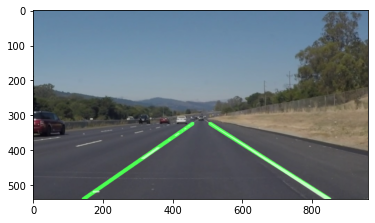

In [13]:
# Display an example image
annotated_image = annotate_image(mpimg.imread('solidWhiteRight.jpg'))
plt.imshow(annotated_image)

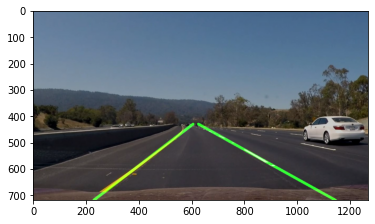

In [14]:
# Display an example image
annotated_image = annotate_image(mpimg.imread('Capture1.jpg'))
plt.imshow(annotated_image)

# Road line detection on video

## Import everything needed to edit/save/watch video clips

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = annotate_image(image)

    return result

# Video processing and output

## Video 1

In [17]:
output1 = 'Output_test1.mp4'
clip1 = VideoFileClip("videotest1.mp4")
white_clip = clip1.fl_image(process_image) #this function expects color images!!
%time white_clip.write_videofile(output1, audio=False)

Moviepy - Building video Output_test1.mp4.
Moviepy - Writing video Output_test1.mp4



Moviepy - Done !
Moviepy - video ready Output_test1.mp4
CPU times: total: 5.27 s
Wall time: 2.86 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

In [19]:
output2 = 'Output_test2.mp4'
clip1 = VideoFileClip("videotest2.mp4")
white_clip = clip1.fl_image(process_image) #this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

Moviepy - Building video Output_test2.mp4.
Moviepy - Writing video Output_test2.mp4



Moviepy - Done !
Moviepy - video ready Output_test2.mp4
CPU times: total: 17.7 s
Wall time: 7.65 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [21]:
## Video challenge

In [22]:
output3 = 'Output_test3.mp4'
clip1 = VideoFileClip("videotest3.mp4")
white_clip = clip1.fl_image(process_image) #this function expects color images!!
%time white_clip.write_videofile(output3, audio=False)

Moviepy - Building video Output_test3.mp4.
Moviepy - Writing video Output_test3.mp4



Moviepy - Done !
Moviepy - video ready Output_test3.mp4
CPU times: total: 10.3 s
Wall time: 5.06 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))

In [24]:
challenge_output1 = 'Output_test_challeng1.mp4'
clip2 = VideoFileClip('videochallenge1.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output1, audio=False)

Moviepy - Building video Output_test_challeng1.mp4.
Moviepy - Writing video Output_test_challeng1.mp4



Moviepy - Done !
Moviepy - video ready Output_test_challeng1.mp4
CPU times: total: 52.6 s
Wall time: 24.1 s


In [25]:
# Display the video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output1))

## Video hard challenge 

In [26]:
challenge_output2 = 'Output_test_challeng2.mp4'
clip2 = VideoFileClip('videochallenge2.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output2, audio=False)

Moviepy - Building video Output_test_challeng2.mp4.
Moviepy - Writing video Output_test_challeng2.mp4



Moviepy - Done !
Moviepy - video ready Output_test_challeng2.mp4
CPU times: total: 30.3 s
Wall time: 13.2 s


In [27]:
# Display the video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output2))